In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import MDS
from PIL import Image
import os
import pingouin as pg
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

import ecoset
import categorization as cat

# Seed for reproducibility
np.random.seed(2023)
tf.random.set_seed(2023)

2023-05-26 11:59:16.277670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 11:59:19.026340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 11:59:19.026453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-26 11:59:19.026464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Dataset
800 images from Ecoset + CUB200.
* Superordinate: 400 vehicles and 400 animals
* Basic: 200 cars, 200 busses, 200 dogs, 200 birds
* Subordinate: 40 per species of birds

Half of these images are from the training set (therefore we'll use it as category knowledge). The other half are from the Train/validation set, so we'll use them in the categorization test.

Images preprocessed by centering the features and resizing to 224x224.

In [2]:
# Load csv
trainCatImgs = pd.read_csv("./deepCatsTrainImages.csv")

# Rename cat columns
trainCatImgs = trainCatImgs.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)

# Add a column delineating train/test set
trainCatImgs["set"] = "train"

trainCatImgs.head()

,path,name,super,basic,sub,set
0,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0030_130191.jpg,animal,bird,CUB_136.Barn_Swallow,train
1,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0065_131555.jpg,animal,bird,CUB_136.Barn_Swallow,train
2,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0060_130110.jpg,animal,bird,CUB_136.Barn_Swallow,train
3,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0042_132043.jpg,animal,bird,CUB_136.Barn_Swallow,train
4,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0016_130678.jpg,animal,bird,CUB_136.Barn_Swallow,train


In [3]:
trainImgFile = "./images/deepCatsTrainImages.npy"

if not os.path.exists(trainImgFile):
    # Preallocate array for images
    trainImages = np.zeros((trainCatImgs.shape[0], 224, 224, 3), dtype=np.float32)

    # Loop through images
    for i, row in trainCatImgs.iterrows():
        # Load image
        img = Image.open(row["path"])

        # Preprocess image
        img = ecoset.preprocess_alexnet(img)

        # Add image to array
        trainImages[i] = img

    # Save images as a npy
    np.save(trainImgFile, trainImages)
else:
    # Load images from npy
    print("Loading images from file...")
    trainImages = np.load(trainImgFile)

print(trainImages.shape)

Loading images from file...
(400, 224, 224, 3)


In [4]:
# Load csv
testCatImgs = pd.read_csv("./deepCatsTestImages.csv")

# Rename cat columns
testCatImgs = testCatImgs.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)

# Add a column delineating train/test set
testCatImgs["set"] = "test"

testCatImgs.head()

,path,name,super,basic,sub,set
0,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0038_132780.jpg,animal,bird,CUB_136.Barn_Swallow,test
1,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0052_131539.jpg,animal,bird,CUB_136.Barn_Swallow,test
2,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0022_130631.jpg,animal,bird,CUB_136.Barn_Swallow,test
3,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0003_130086.jpg,animal,bird,CUB_136.Barn_Swallow,test
4,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0023_130325.jpg,animal,bird,CUB_136.Barn_Swallow,test


In [5]:
testImgFile = "./images/deepCatsTestImages.npy"

if not os.path.exists(testImgFile):
    # Preallocate array for images
    testImages = np.zeros((testCatImgs.shape[0], 224, 224, 3), dtype=np.float32)

    # Loop through images
    for i, row in testCatImgs.iterrows():
        # Load image
        img = Image.open(row["path"])

        # Preprocess image
        img = ecoset.preprocess_alexnet(img)

        # Add image to array
        testImages[i] = img

    # Save images as a npy
    np.save(testImgFile, testImages)
else:
    # Load images from npy
    print("Loading images from file...")
    testImages = np.load(testImgFile)

print(testImages.shape)

Loading images from file...
(400, 224, 224, 3)


# Models and representations
Generate representations from AlexNet trained in Mehrer et al 2022. 
* 10 models are trained on Ecoset (basic-level categories)
* 10 models are trained on ImageNet (mixed levels of abstraction)

In [6]:
# Load example model
weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89"
model = ecoset.make_alex_net_v2(weights_path=weightPath)
model.summary()

2023-05-26 11:59:26.377724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 11:59:26.483819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 11:59:26.484760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 11:59:26.488296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 54, 54, 64)        23296     
                                                                 
 pool1 (MaxPooling2D)        (None, 26, 26, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 26, 26, 192)       307392    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 192)       0         
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 384)       663936    
         

In [7]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Get ecoset representations
ecosetTrainReps = np.zeros(
    (len(seeds), trainImages.shape[0], 4096 * 5 * 5), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/ecoset/seed{seed:02}_train_reps.npy"

    if not os.path.exists(repFile):
        # Load model
        weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(trainImages)
        # Flatten representation
        reps = reps.reshape(reps.shape[0], -1)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    ecosetTrainReps[i] = reps

ecosetTrainReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 102400)

In [8]:
# Get imagenet representations
imagenetTrainReps = np.zeros(
    (len(seeds), trainImages.shape[0], 4096 * 5 * 5), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/imagenet/seed{seed:02}_train_reps.npy"

    if not os.path.exists(repFile):
        # Load model
        weightPath = f"./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath, output_shape=1000)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(trainImages)
        # Flatten representation
        reps = reps.reshape(reps.shape[0], -1)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    imagenetTrainReps[i] = reps

imagenetTrainReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 102400)

In [9]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Get ecoset representations
ecosetTestReps = np.zeros(
    (len(seeds), testImages.shape[0], 4096 * 5 * 5), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/ecoset/seed{seed:02}_test_reps.npy"

    if not os.path.exists(repFile):
        # Load model
        weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(testImages)
        # Flatten representation
        reps = reps.reshape(reps.shape[0], -1)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    ecosetTestReps[i] = reps

ecosetTestReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 102400)

In [10]:
# Get imagenet representations
imagenetTestReps = np.zeros(
    (len(seeds), testImages.shape[0], 4096 * 5 * 5), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/imagenet/seed{seed:02}_test_reps.npy"

    if not os.path.exists(repFile):
        # Load model
        weightPath = f"./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath, output_shape=1000)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(testImages)
        # Flatten representation
        reps = reps.reshape(reps.shape[0], -1)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    imagenetTestReps[i] = reps

imagenetTestReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 102400)

# Categorization
We use a LBA to simulate a category verification task where each model is a 
different participant. We perform the task in each level of abstraction. For 
each image, we calculate a drift rate to verify that that image belongs to its
category by calculating similarity of that image's representation with the 
similarity of every other image of the same category (GCM-like).

In [11]:
criterion = 10.5
maxImgs = 20

performanceFile = f"./cat_performance_crit{criterion}_maxImgs{maxImgs}.csv"
if not os.path.exists(performanceFile):
    performance = pd.DataFrame(
        columns=["seed", "model", "image", "category", "level", "response", "RT"]
    )
    for level in ["super", "basic", "sub"]:
        performance = pd.concat(
            [
                performance,
                cat.simulate_cat_verification(
                    testReps=ecosetTestReps,
                    memoryReps=ecosetTrainReps,
                    testImgInfo=testCatImgs,
                    memoryImgInfo=trainCatImgs,
                    categoryCol=level,
                    modelName="ecoset",
                    simFun=cat.gcm_sim,
                    criterion=criterion,
                    maxImgs=maxImgs,
                ),
            ]
        )

        performance = pd.concat(
            [
                performance,
                cat.simulate_cat_verification(
                    testReps=imagenetTestReps,
                    memoryReps=imagenetTrainReps,
                    testImgInfo=testCatImgs,
                    memoryImgInfo=trainCatImgs,
                    categoryCol=level,
                    modelName="imagenet",
                    simFun=cat.gcm_sim,
                    criterion=criterion,
                    maxImgs=maxImgs,
                ),
            ]
        )

    performance.to_csv(performanceFile, index=False)
else:
    print("Loading performance from file")
    performance = pd.read_csv(performanceFile)

print(
    performance.groupby(["model", "level"])["response"].agg(
        lambda x: np.mean(x == "yes")
    )
)
print(performance.groupby(["model", "level"])["RT"].agg(["mean", "std"]))

Loading performance from file
model     level
ecoset    basic    0.98175
          sub      1.00000
          super    0.95625
imagenet  basic    0.40325
          sub      0.05400
          super    0.25450
Name: response, dtype: float64
                    mean       std
model    level                    
ecoset   basic  0.952709  0.019875
         sub    0.948066  0.013546
         super  0.963191  0.017322
imagenet basic  0.959549  0.027958
         sub    0.967998  0.019620
         super  0.954917  0.037243


# ANOVA Analysis
We treat each model as a different participant so we do a mixed effects ANOVA where we have a between subject factor of training set (Ecoset or Imagenet) and a within-subject factor of level of categorization (Superordinate, basic, subordiante).

In [12]:
# Add a subject column that is a combo of model and seed
performance["subject"] = performance["model"] + performance["seed"].astype(str)

# Group data by model and level
sbjData = (
    performance.groupby(["subject", "model", "level"])
    .agg({"response": [lambda x: np.mean(x == "yes")], "RT": ["mean"]})
    .reset_index()
)
sbjData.columns = sbjData.columns.droplevel(1)
sbjData = sbjData.rename(columns={"response": "accuracy", "RT": "RT"})
sbjData.head()

,subject,model,level,accuracy,RT
0,ecoset1,ecoset,basic,0.9800,0.952664
1,ecoset1,ecoset,sub,1.0000,0.947750
2,ecoset1,ecoset,super,0.9675,0.962493
3,ecoset10,ecoset,basic,0.9850,0.951660
4,ecoset10,ecoset,sub,1.0000,0.947048


In [13]:
pg.mixed_anova(
    sbjData, dv="accuracy", within="level", between="model", subject="subject"
)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,8.260315,1,18,8.260315,20196.712369,6.529705e-29,0.999110,NaN
1,level,0.274158,2,36,0.137079,796.905733,1.566651e-30,0.977912,0.50884
2,Interaction,0.349841,2,36,0.174921,1016.898870,2.121987e-32,0.982607,NaN


In [14]:
pg.mixed_anova(sbjData, dv="RT", within="level", between="model", subject="subject")

/data/venv/research2/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,0.000570,1,18,0.000570,118.531901,2.377258e-09,0.868163,NaN
1,level,0.000088,2,36,0.000044,88.293283,1.311597e-14,0.830657,0.502337
2,Interaction,0.001992,2,36,0.000996,1995.466277,1.330168e-37,0.991060,NaN


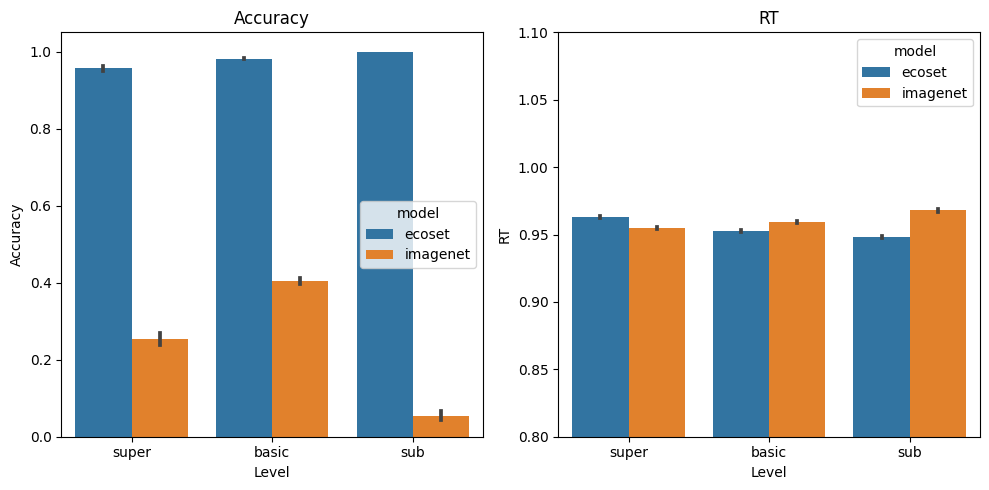

In [15]:
# Plot accuracy and RT
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# Accuracy
sns.barplot(
    data=sbjData,
    x="level",
    y="accuracy",
    hue="model",
    ax=ax[0],
    order=["super", "basic", "sub"],
)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Accuracy")

# RT
sns.barplot(
    data=sbjData,
    x="level",
    y="RT",
    hue="model",
    ax=ax[1],
    order=["super", "basic", "sub"],
)
# Set y range
ax[1].set_ylim(0.8, 1.1)
ax[1].set_title("RT")
ax[1].set_xlabel("Level")
ax[1].set_ylabel("RT")

plt.tight_layout()
plt.show()

# MDS Analysis
We now look at how the categories are represented in the representational space. 

In [16]:
# Concatenate representations between train and test
ecosetReps = np.concatenate((ecosetTrainReps, ecosetTestReps), axis=1)
ecosetImgSimMatFile = "./representations/ecoset_img_sim_mat.npy"

if not os.path.exists(ecosetImgSimMatFile):
    ecosetSimMat = np.zeros(
        (len(seeds), ecosetReps.shape[1], ecosetReps.shape[1]), dtype=np.float32
    )
    for i in range(len(seeds)):
        ecosetSimMat[i] = squareform(pdist(ecosetReps[i], metric=cat.gcm_sim))

    np.save(ecosetImgSimMatFile, ecosetSimMat)
else:
    ecosetSimMat = np.load(ecosetImgSimMatFile)

del ecosetReps

ecosetSimMat = np.mean(ecosetSimMat, axis=0)
# Set diagonal to 1
np.fill_diagonal(ecosetSimMat, 1)
ecosetSimMat.shape

(800, 800)

In [17]:
imagenetReps = np.concatenate((imagenetTrainReps, imagenetTestReps), axis=1)
imagenetImgSimMatFile = "./representations/imagenet_img_sim_mat.npy"

if not os.path.exists(imagenetImgSimMatFile):
    imagenetSimMat = np.zeros(
        (len(seeds), imagenetReps.shape[1], imagenetReps.shape[1]), dtype=np.float32
    )
    for i in range(len(seeds)):
        imagenetSimMat[i] = squareform(pdist(imagenetReps[i], metric=cat.gcm_sim))

    np.save(imagenetImgSimMatFile, imagenetSimMat)
else:
    imagenetSimMat = np.load(imagenetImgSimMatFile)

del imagenetReps

imagenetSimMat = np.mean(imagenetSimMat, axis=0)
# Set diagonal to 1
np.fill_diagonal(ecosetSimMat, 1)
imagenetSimMat.shape

(800, 800)

In [18]:
# Turn similarity matrices to distance matrices
ecosetDistMat = 1 - ecosetSimMat
imagenetDistMat = 1 - imagenetSimMat

eps = 1e-3
metric = True

# Create MDS for Ecoset
ecosetMDS = MDS(
    n_components=2,
    dissimilarity="precomputed",
    normalized_stress="auto",
    metric=metric,
    eps=eps,
    n_init=10,
    random_state=0,
)
ecosetSolution = ecosetMDS.fit_transform(ecosetDistMat)
print(ecosetMDS.stress_)

# Create MDS for Imagenet
imagenetMDS = MDS(
    n_components=2,
    dissimilarity="precomputed",
    normalized_stress="auto",
    metric=metric,
    eps=eps,
    n_init=10,
    random_state=0,
)
imagenetSolution = imagenetMDS.fit_transform(imagenetDistMat)
print(imagenetMDS.stress_)

ecosetSolution.shape

9184.386750911617
13226.773696571006


(800, 2)

In [19]:
# Concatenate df for both train and test images
catImgs = pd.concat([trainCatImgs, testCatImgs], axis=0)
# Reset index
catImgs = catImgs.reset_index(drop=True)

# Color mapping
colorMap = {
    "bird": sns.color_palette(n_colors=4)[0],
    "dog": sns.color_palette(n_colors=4)[1],
    "car": sns.color_palette(n_colors=4)[2],
    "bus": sns.color_palette(n_colors=4)[3],
}
colors = list(catImgs["basic"].map(colorMap))
# Market mapping
markerMap = {
    float("nan"): "o",
    "CUB_002.Laysan_Albatross": "s",
    "CUB_048.European_Goldfinch": "s",
    "CUB_094.White_breasted_Nuthatch": "p",
    "CUB_136.Barn_Swallow": "P",
    "CUB_199.Winter_Wren": "*",
}
markers = list(catImgs["sub"].map(markerMap))

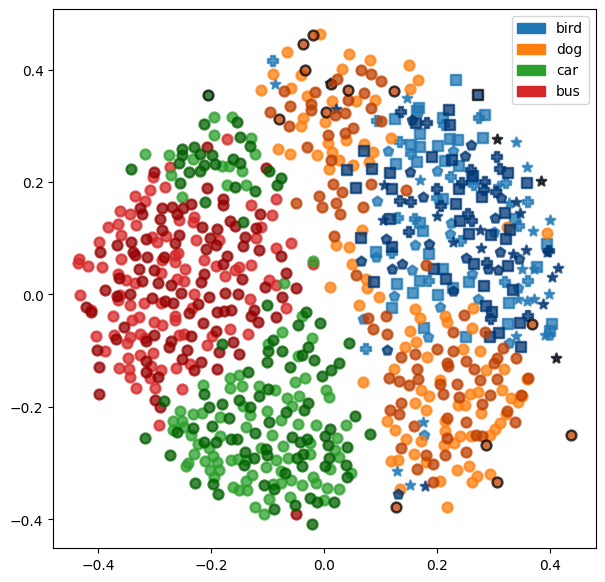

In [20]:
# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot MDS
for i, row in catImgs.iterrows():
    edgecolors = None
    color = colors[i]
    if row["set"] == "test":
        color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
        logIdx = (
            (performance["model"] == "ecoset")
            & (performance["image"] == row["name"])
            & (performance["level"] == "basic")
        )
        noResponses = performance.loc[logIdx]["response"].values == "no"
        if np.any(noResponses):
            edgecolors = "k"

    ax.scatter(
        ecosetSolution[i, 0],
        ecosetSolution[i, 1],
        s=50,
        color=color,
        marker=markers[i],
        edgecolors=edgecolors,
        alpha=0.75,
        linewidths=1.75,
    )

legendHandles = [
    mpatches.Patch(color=colorMap["bird"], label="bird"),
    mpatches.Patch(color=colorMap["dog"], label="dog"),
    mpatches.Patch(color=colorMap["car"], label="car"),
    mpatches.Patch(color=colorMap["bus"], label="bus"),
]
ax.legend(handles=legendHandles, loc="upper right")

fig.show()

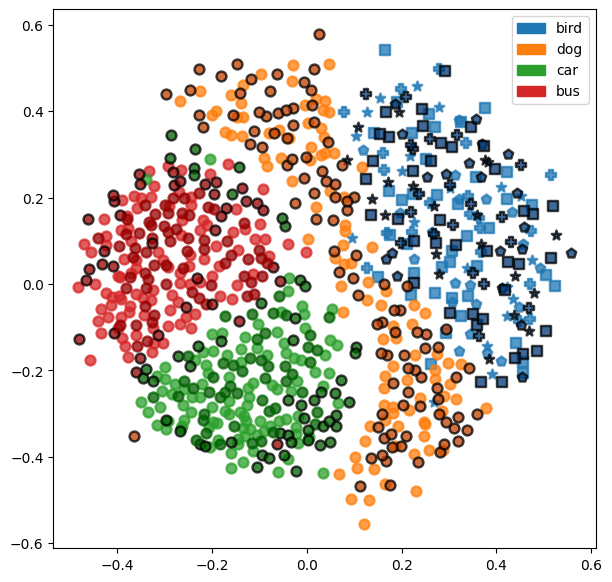

In [21]:
# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot MDS
for i, row in catImgs.iterrows():
    edgecolors = None
    color = colors[i]
    if row["set"] == "test":
        color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
        logIdx = (
            (performance["model"] == "imagenet")
            & (performance["image"] == row["name"])
            & (performance["level"] == "basic")
        )
        noResponses = performance.loc[logIdx]["response"].values == "no"
        if np.any(noResponses):
            edgecolors = "k"

    ax.scatter(
        imagenetSolution[i, 0],
        imagenetSolution[i, 1],
        s=50,
        color=color,
        marker=markers[i],
        edgecolors=edgecolors,
        alpha=0.75,
        linewidths=1.75,
    )

legendHandles = [
    mpatches.Patch(color=colorMap["bird"], label="bird"),
    mpatches.Patch(color=colorMap["dog"], label="dog"),
    mpatches.Patch(color=colorMap["car"], label="car"),
    mpatches.Patch(color=colorMap["bus"], label="bus"),
]
ax.legend(handles=legendHandles, loc="upper right")

fig.show()

# Cluster Indices
Now we calculate cluster indices.

$ cluster index = MeanBetweenCategorySimilarity - MeanWithinCategorySimilarity $

The bigger the better because we are using Euclidean distance for similarity.

In [27]:
levelMap = {
    "super": ["animal", "vehicle"],
    "basic": ["bird", "dog", "car", "bus"],
    "sub": [
        "CUB_002.Laysan_Albatross",
        "CUB_048.European_Goldfinch",
        "CUB_094.White_breasted_Nuthatch",
        "CUB_136.Barn_Swallow",
        "CUB_199.Winter_Wren",
    ],
}

simCluster = {}
for imgSet in ["train", "test"]:
    for model in ["ecoset", "imagenet"]:
        simMat = ecosetSimMat if model == "ecoset" else imagenetSimMat
        for level in ["super", "basic", "sub"]:
            for category in levelMap[level]:
                cluster = cat.cluster_index(catImgs, level, category, imgSet, simMat)
                # print(f"{imgSet} {model} {level} {category} cluster: {cluster}")
                simCluster[imgSet + "-" + category] = cluster

train ecoset super animal cluster: 0.038464808926158556
train ecoset super vehicle cluster: 0.06735924723694231
train ecoset basic bird cluster: 0.044189350299793095
train ecoset basic dog cluster: 0.0348149929765198
train ecoset basic car cluster: 0.06413587241982566
train ecoset basic bus cluster: 0.08426881223450411
train ecoset sub CUB_002.Laysan_Albatross cluster: 0.04710838617070723
train ecoset sub CUB_048.European_Goldfinch cluster: 0.05983624771629514
train ecoset sub CUB_094.White_breasted_Nuthatch cluster: 0.05567204965964745
train ecoset sub CUB_136.Barn_Swallow cluster: 0.04775969369631061
train ecoset sub CUB_199.Winter_Wren cluster: 0.06042306616902349
train imagenet super animal cluster: 0.006620624391622254
train imagenet super vehicle cluster: 0.08523127703335714
train imagenet basic bird cluster: 0.02980502626664111
train imagenet basic dog cluster: 0.021160840890654398
train imagenet basic car cluster: 0.08309206420041698
train imagenet basic bus cluster: 0.09035651

In [29]:
simCluster

{'train-animal': 0.006620624391622254,
 'train-vehicle': 0.08523127703335714,
 'train-bird': 0.02980502626664111,
 'train-dog': 0.021160840890654398,
 'train-car': 0.08309206420041698,
 'train-bus': 0.09035651736900663,
 'train-CUB_002.Laysan_Albatross': 0.0521808401652073,
 'train-CUB_048.European_Goldfinch': 0.0710251464733952,
 'train-CUB_094.White_breasted_Nuthatch': 0.05730374304479674,
 'train-CUB_136.Barn_Swallow': 0.04748941621890196,
 'train-CUB_199.Winter_Wren': 0.06326867009464066,
 'test-animal': 0.00310241426835256,
 'test-vehicle': 0.08465304277381258,
 'test-bird': 0.03398537213025671,
 'test-dog': 0.017737006783906883,
 'test-car': 0.0724108935760428,
 'test-bus': 0.08958456819138738,
 'test-CUB_002.Laysan_Albatross': 0.048329332255219126,
 'test-CUB_048.European_Goldfinch': 0.06563047970203972,
 'test-CUB_094.White_breasted_Nuthatch': 0.06862099807905525,
 'test-CUB_136.Barn_Swallow': 0.05816596911926014,
 'test-CUB_199.Winter_Wren': 0.06780027291100282}

In [32]:
superTrainCluster = [
    value
    for key, value in simCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "train"
]
superTrainCluster = np.mean(superTrainCluster)
superTestCluster = [
    value
    for key, value in simCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "test"
]
superTestCluster = np.mean(superTestCluster)

basicTrainCluster = [
    value 
    for key, value in simCluster.items() 
    if key.split('-')[-1] in levelMap['basic'] and key.split('-')[0] == 'train'
]
basicTrainCluster = np.mean(basicTrainCluster)
basicTestCluster = [
    value
    for key, value in simCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "test"
]
basicTestCluster = np.mean(basicTestCluster)

subTrainCluster = [
    value
    for key, value in simCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "train"
]
subTrainCluster = np.mean(subTrainCluster)
subTestCluster = [
    value
    for key, value in simCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "test"
]
subTestCluster = np.mean(subTestCluster)

print(f"Super train cluster index: {superTrainCluster}")
print(f"Super test cluster index: {superTestCluster}")
print(f"Basic train cluster index: {basicTrainCluster}")
print(f"Basic test cluster index: {basicTestCluster}")
print(f"Sub train cluster index: {subTrainCluster}")
print(f"Sub test cluster index: {subTestCluster}")

Super train cluster index: 0.0459259507124897
Super test cluster index: 0.04387772852108257
Basic train cluster index: 0.05610361218167978
Basic test cluster index: 0.05342946017039844
Sub train cluster index: 0.05825356319938837
Sub test cluster index: 0.061709410413315416
